# IMAGE CLASSIFICATION USING CIFAR-10 DATASET: A COMPARISON OF MANHATTAN (L1) AND EUCLIDEAN (L2) DISTANCES WITH 5-FOLD CROSS-VALIDATION

In [116]:
# library import packages, 
import numpy as np
from  tensorflow.keras.datasets import cifar10
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier

Import Data from cifar10 Datasets,

In [117]:
(x_train,y_train),(x_test,y_test) = cifar10.load_data()

print("Training Data Shape : ", x_train.shape)
print("Training labels Shape : ", y_train.shape)
print("Testing Data Shape : ", x_test.shape)
print("Testing Label Shape : ", y_test.shape)

Training Data Shape :  (50000, 32, 32, 3)
Training labels Shape :  (50000, 1)
Testing Data Shape :  (10000, 32, 32, 3)
Testing Label Shape :  (10000, 1)


Pre-Processing the Data, 

Visualize Data

In [118]:
plt.rcParams['figure.figsize'] = (12.0,8.0)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['font.size'] = 10
plt.rcParams['image.cmap'] = 'gray'

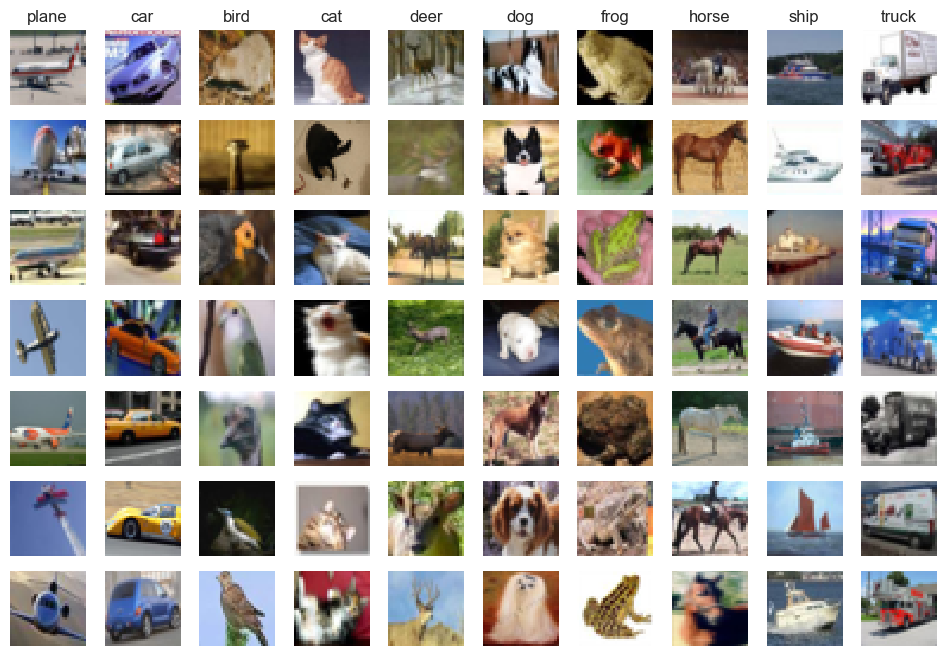

In [119]:
# Show some train images, 
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
sample_per_classes = 7

for y,cls in enumerate(classes):
    indexs = np.flatnonzero(y_train==y)
    indexs = np.random.choice(indexs,sample_per_classes,replace=False)
    for i,index in enumerate(indexs):
        plt_index = i*num_classes+y+1
        plt.subplot(sample_per_classes,num_classes,plt_index)
        plt.imshow(x_train[index].astype('uint8'))
        plt.axis('off')
        if i==0:
            plt.title(cls)

plt.show()


In [120]:

# Reshape
x_train = x_train.reshape(50000,32*32*3)
x_test = x_test.reshape(10000, 32*32*3)


# Gaussian Normalization or z-score, 
x_train = (x_train-np.mean(x_train))/np.std(x_train)
x_test = (x_test-np.mean(x_test))/np.std(x_test)

print("X train Data : ", x_train)
print("X Test Data : ", x_test)

X train Data :  [[-0.96192505 -0.91515971 -0.89957127 ...  0.0357355  -0.44750633
  -0.75927525]
 [ 0.51897733  0.87751159  1.03339605 ...  0.34750442  0.19161996
   0.36309287]
 [ 2.09341038  2.09341038  2.09341038 ... -0.63456768 -0.54103701
  -0.5722139 ]
 ...
 [-1.33604776  0.89310003  1.78164146 ... -1.69458202 -1.39840154
  -1.10222107]
 [ 1.06457294  1.40751875  1.85958369 ...  1.15810362  1.08016139
   0.78398091]
 [ 1.68811078  1.68811078  1.84399524 ...  0.65927334  0.65927334
   0.62809645]]
X Test Data :  [[ 0.56931459 -0.14875133 -1.13218945 ... -1.56927306 -0.85120713
  -0.17997159]
 [ 1.77129452  1.77129452  1.77129452 ...  1.0063982   1.22494001
   1.20932988]
 [ 0.56931459  1.06883872  1.56836284 ... -1.78781487 -1.77220474
  -1.78781487]
 ...
 [-1.58488319 -1.66293384 -1.70976422 ... -1.50683255 -1.58488319
  -1.16340971]
 [-1.50683255 -1.27268061 -1.70976422 ... -0.46095391 -0.0238703
  -0.64827546]
 [-0.75754636 -0.67949572 -0.7263261  ... -1.47561229 -1.49122242
  

Sub-sampling

In [121]:
num_training = 5000
mask = list(range(num_training))
x_train = x_train[mask]
y_train = y_train[mask]

num_test = 500
mask = list(range(num_test))
x_test = x_test[mask]
y_test = y_test[mask]

# Reshape Images, 
x_train = np.reshape(x_train,(x_train.shape[0],-1))
x_test = np.reshape(x_test,(x_test.shape[0],-1))
print(x_train.shape, x_test.shape)


(5000, 3072) (500, 3072)


Model Building and Evaluation:

In [125]:
import numpy as np
from scipy import stats


class KNearestNeighbor(object):
  """ a kNN classifier with L2 distance """

  def __init__(self):
    pass

  def train(self, X, y):
    """
    Train the classifier. For k-nearest neighbors this is just
    memorizing the training data.

    Inputs:
    - X: A numpy array of shape (num_train, D) containing the training data
      consisting of num_train samples each of dimension D.
    - y: A numpy array of shape (N,) containing the training labels, where
         y[i] is the label for X[i].
    """
    self.X_train = X
    self.y_train = y

  def predict(self, X, k=1, num_loops=0):
    """
    Predict labels for test data using this classifier.

    Inputs:
    - X: A numpy array of shape (num_test, D) containing test data consisting
         of num_test samples each of dimension D.
    - k: The number of nearest neighbors that vote for the predicted labels.
    - num_loops: Determines which implementation to use to compute distances
      between training points and testing points.

    Returns:
    - y: A numpy array of shape (num_test,) containing predicted labels for the
      test data, where y[i] is the predicted label for the test point X[i].
    """
    if num_loops == 0:
      dists = self.compute_distances_no_loops(X)
    elif num_loops == 1:
      dists = self.compute_distances_one_loop(X)
    elif num_loops == 2:
      dists = self.compute_distances_two_loops(X)
    else:
      raise ValueError('Invalid value %d for num_loops' % num_loops)

    return self.predict_labels(dists, k=k)

  def compute_distances_two_loops(self, X):
    """
    Compute the distance between each test point in X and each training point
    in self.X_train using a nested loop over both the training data and the
    test data.

    Inputs:
    - X: A numpy array of shape (num_test, D) containing test data.

    Returns:
    - dists: A numpy array of shape (num_test, num_train) where dists[i, j]
      is the Euclidean distance between the ith test point and the jth training
      point.
    """
    num_test = X.shape[0]
    num_train = self.X_train.shape[0]
    dists = np.zeros((num_test, num_train))
    for i in xrange(num_test):
      for j in xrange(num_train):
        difference = X[i] - self.X_train[j]
        dists[i, j] = np.sqrt(np.dot(difference, difference))
    return dists

  def compute_distances_one_loop(self, X):
    """
    Compute the distance between each test point in X and each training point
    in self.X_train using a single loop over the test data.

    Input / Output: Same as compute_distances_two_loops
    """
    # TODO: Can't figure out a single loop that's faster than the
    # double loop above. So until it's figured out, we reuse that.
    return self.compute_distances_two_loops(X)

  def compute_distances_no_loops(self, X):
    """
    Compute the distance between each test point in X and each training point
    in self.X_train using no explicit loops.

    Input / Output: Same as compute_distances_two_loops
    """
    num_test = X.shape[0]
    num_train = self.X_train.shape[0]
    dists = np.zeros((num_test, num_train))

    test_square = np.sum(np.square(X), axis=1)
    train_square = np.sum(np.square(self.X_train), axis=1)
    product = np.dot(X, self.X_train.T)
    dists = np.sqrt(test_square.reshape(-1, 1) + train_square - 2*product)
    return dists

  def predict_labels(self, dists, k=1):
    """
    Given a matrix of distances between test points and training points,
    predict a label for each test point.

    Inputs:
    - dists: A numpy array of shape (num_test, num_train) where dists[i, j]
      gives the distance betwen the ith test point and the jth training point.

    Returns:
    - y: A numpy array of shape (num_test,) containing predicted labels for the
      test data, where y[i] is the predicted label for the test point X[i].
    """
    num_test = dists.shape[0]
    y_pred = np.zeros(num_test)
    for i in xrange(num_test):
      # A list of length k storing the labels of the k nearest neighbors to
      # the ith test point.
      closest_y = []
      k_nearest_idx = np.argsort(dists[i, :])[0:k]
      closest_y = self.y_train[k_nearest_idx]
      y_pred = stats.mode(closest_y)
    return y_pred


In [126]:
# Classifier, 
from sklearn.neighbors import KNeighborsClassifier

classifier = KNearestNeighbor()
classifier.train(x_train,y_train)

[[ 59.28592794  65.88011776  86.01544208 ...  62.61772727  65.97267992
   67.62949965]
 [ 98.55381863  82.05298335  62.82913414 ...  75.06822934  73.23113835
  120.80042829]
 [ 81.29620472  66.29547529  58.86475233 ...  58.632884    69.83471996
   98.77125859]
 ...
 [ 83.42116587  78.86484428  99.15506091 ...  79.77613563  70.8453674
   91.90941982]
 [ 57.09812223  60.28713679  75.68936536 ...  54.90910445  50.03093964
   69.00406529]
 [108.02778193  94.43397629  98.42572029 ...  94.36076564  63.91958055
  124.81819993]]


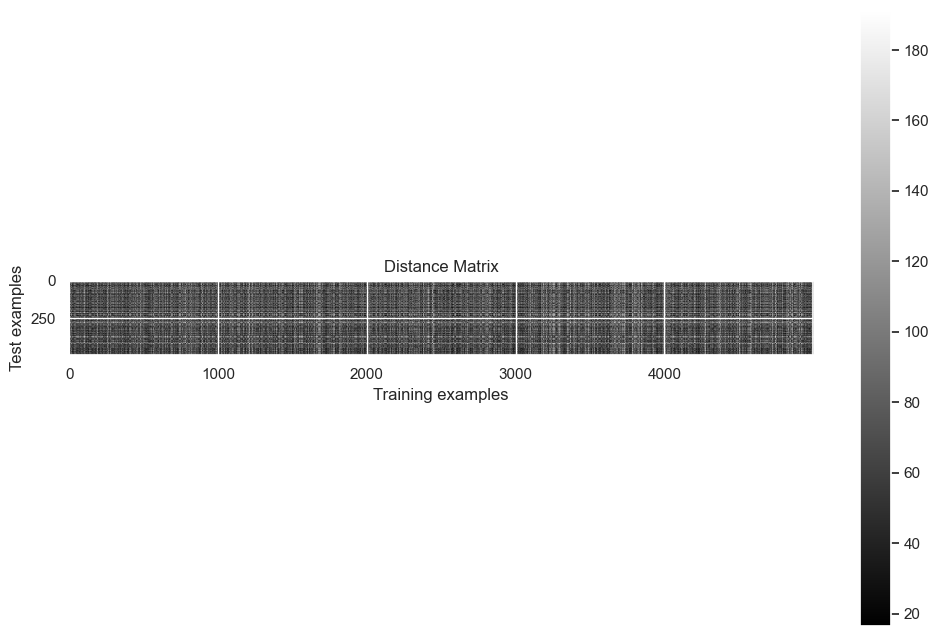

In [127]:
import numpy as np
import matplotlib.pyplot as plt

def compute_distance(x1, x2):
    return np.sqrt(np.sum((x1 - x2)**2))

def compute_distances(X_train, X_test):
    num_test = X_test.shape[0]
    num_train = X_train.shape[0]
    dists = np.zeros((num_test, num_train))
    
    for i in range(num_test):
        for j in range(num_train):
            dists[i, j] = compute_distance(X_test[i], X_train[j])
    
    return dists

# Compute distances
dists = compute_distances(x_train,x_test)
print(dists)
# Visualize the distance matrix
plt.imshow(dists, interpolation='none')
plt.colorbar()
plt.xlabel('Training examples')
plt.ylabel('Test examples')
plt.title('Distance Matrix')
plt.show()

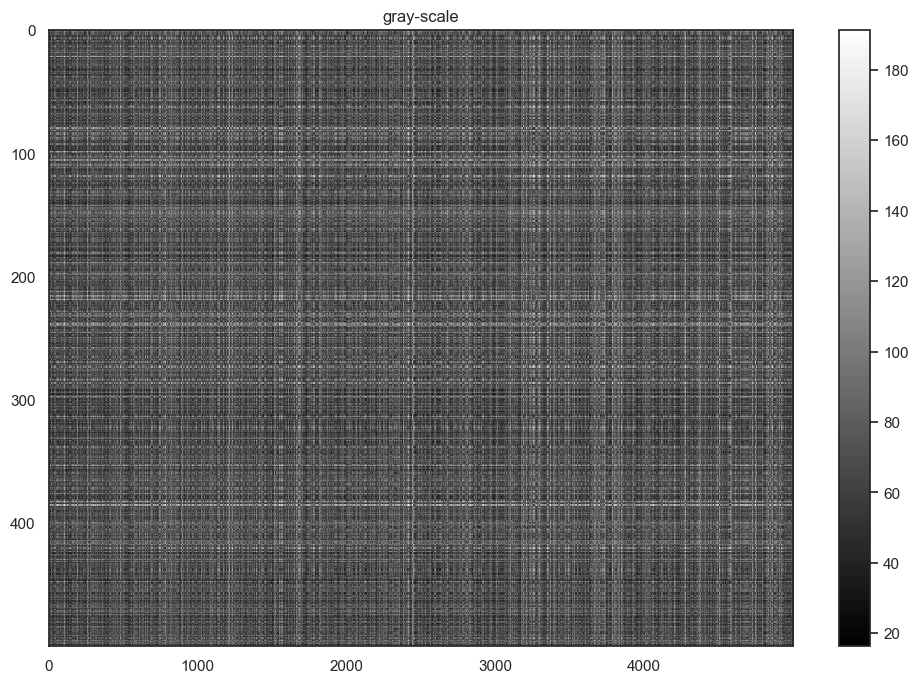

In [128]:
import seaborn as sns
sns.set()
with sns.axes_style('white'):
  plt.imshow(dists, aspect='auto', cmap='gray')
  plt.title("gray-scale")
  plt.colorbar()

We will use two distance metrics, Manhattan (L1) and Euclidean (L2), to measure the similarity between images.

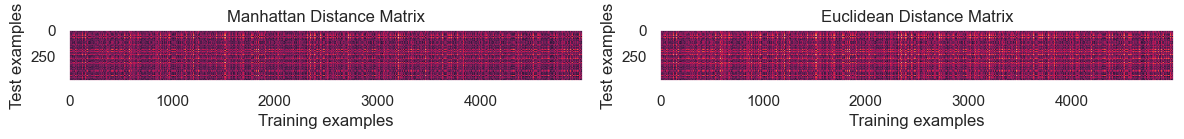

In [129]:
import numpy as np
import matplotlib.pyplot as plt

def compute_manhattan_distance(x1, x2):
    # Compute the Manhattan (L1) distance between two data points
    return np.sum(np.abs(x1 - x2))

def compute_euclidean_distance(x1, x2):
    # Compute the Euclidean (L2) distance between two data points
    return np.sqrt(np.sum((x1 - x2)**2))

def compute_distances(X_train, X_test):
    num_test = X_test.shape[0]
    num_train = X_train.shape[0]
    dists_manhattan = np.zeros((num_test, num_train))
    dists_euclidean = np.zeros((num_test, num_train))
    
    for i in range(num_test):
        for j in range(num_train):
            dists_manhattan[i, j] = compute_manhattan_distance(X_test[i], X_train[j])
            dists_euclidean[i, j] = compute_euclidean_distance(X_test[i], X_train[j])
    
    return dists_manhattan, dists_euclidean


# Compute distances
dists_manhattan, dists_euclidean = compute_distances(x_train,x_test)

# Visualize the distance matrices
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].imshow(dists_manhattan, interpolation='none')
axes[0].set_title('Manhattan Distance Matrix')
axes[0].set_xlabel('Training examples')
axes[0].set_ylabel('Test examples')
axes[0].grid(False)

axes[1].imshow(dists_euclidean, interpolation='none')
axes[1].set_title('Euclidean Distance Matrix')
axes[1].set_xlabel('Training examples')
axes[1].set_ylabel('Test examples')
axes[1].grid(False)

plt.tight_layout()
plt.show()


In [130]:
from sklearn.model_selection import cross_val_score,KFold
from sklearn.neighbors import KNeighborsClassifier

def Cross_Validation(k):
    knn_model = KNeighborsClassifier(n_neighbors=k)  #here defines the value of K, 
    k_Fold = KFold(n_splits=5)
    scores = cross_val_score(knn_model,x_train,y_train,cv=k_Fold)

    # Show Cross Validation Data, 
    print(f"When Value of K is {k} => ")
    print("Cross Validation Scores : ", scores)
    print("Average CV Score : ", scores.mean())
    print("Number of cv Scores used in Average : ", len(scores),"\n")
    

Cross_Validation(1)
Cross_Validation(5)
Cross_Validation(10)

c:\Users\DELL\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neighbors\_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
c:\Users\DELL\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neighbors\_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
c:\Users\DELL\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neighbors\_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
c:\Users\DELL\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neighbors\_classification.py:238: Data

When Value of K is 1 => 
Cross Validation Scores :  [0.263 0.257 0.264 0.278 0.266]
Average CV Score :  0.2656
Number of cv Scores used in Average :  5 



c:\Users\DELL\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neighbors\_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
c:\Users\DELL\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neighbors\_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
c:\Users\DELL\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neighbors\_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
c:\Users\DELL\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neighbors\_classification.py:238: Data

When Value of K is 5 => 
Cross Validation Scores :  [0.248 0.266 0.28  0.292 0.28 ]
Average CV Score :  0.2732
Number of cv Scores used in Average :  5 



c:\Users\DELL\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neighbors\_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
c:\Users\DELL\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neighbors\_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
c:\Users\DELL\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neighbors\_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
c:\Users\DELL\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neighbors\_classification.py:238: Data

When Value of K is 10 => 
Cross Validation Scores :  [0.265 0.296 0.276 0.284 0.28 ]
Average CV Score :  0.2802
Number of cv Scores used in Average :  5 



Result And Analysis:

c:\Users\DELL\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neighbors\_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
c:\Users\DELL\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neighbors\_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
c:\Users\DELL\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neighbors\_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
c:\Users\DELL\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neighbors\_classification.py:238: Data

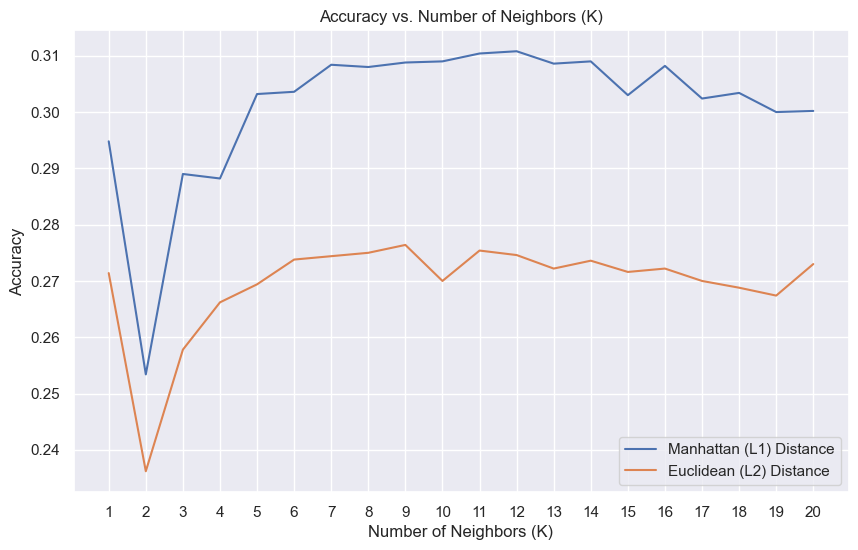

In [131]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score, KFold

# Define range of K values to test, 
k_values = range(1, 21)  

# Initialize lists to store average accuracy for each value of K
avg_accuracy_manhattan = []
avg_accuracy_euclidean = []


for k in k_values:
    # Initialize KNN classifier for Manhattan distance
    knn_manhattan = KNeighborsClassifier(n_neighbors=k, metric='manhattan')
    
    # Initialize KNN classifier for Euclidean distance
    knn_euclidean = KNeighborsClassifier(n_neighbors=k, metric='euclidean')

    # Initialize cross-validation splitter
    kf = KFold(n_splits=5, shuffle=True, random_state=42)

    # Perform 5-fold cross-validation for Manhattan distance
    accuracy_scores_manhattan = cross_val_score(knn_manhattan, x_train, y_train, cv=kf, scoring='accuracy')
    avg_accuracy_manhattan.append(accuracy_scores_manhattan.mean())

    # Perform 5-fold cross-validation for Euclidean distance
    accuracy_scores_euclidean = cross_val_score(knn_euclidean, x_train, y_train, cv=kf, scoring='accuracy')
    avg_accuracy_euclidean.append(accuracy_scores_euclidean.mean())

# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot(k_values, avg_accuracy_manhattan, label='Manhattan (L1) Distance')
plt.plot(k_values, avg_accuracy_euclidean, label='Euclidean (L2) Distance')
plt.title('Accuracy vs. Number of Neighbors (K)')
plt.xlabel('Number of Neighbors (K)')
plt.ylabel('Accuracy')
plt.xticks(k_values)
plt.legend()
plt.grid(True)
plt.show()


Top 5 Predictions

In [132]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler

# Standard Scaler, 
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
y_test = scaler.transform(x_test)

# Model of knn, 
knn = KNeighborsClassifier()
knn.fit(x_train,y_train)


c:\Users\DELL\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neighbors\_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


KNeighborsClassifier()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

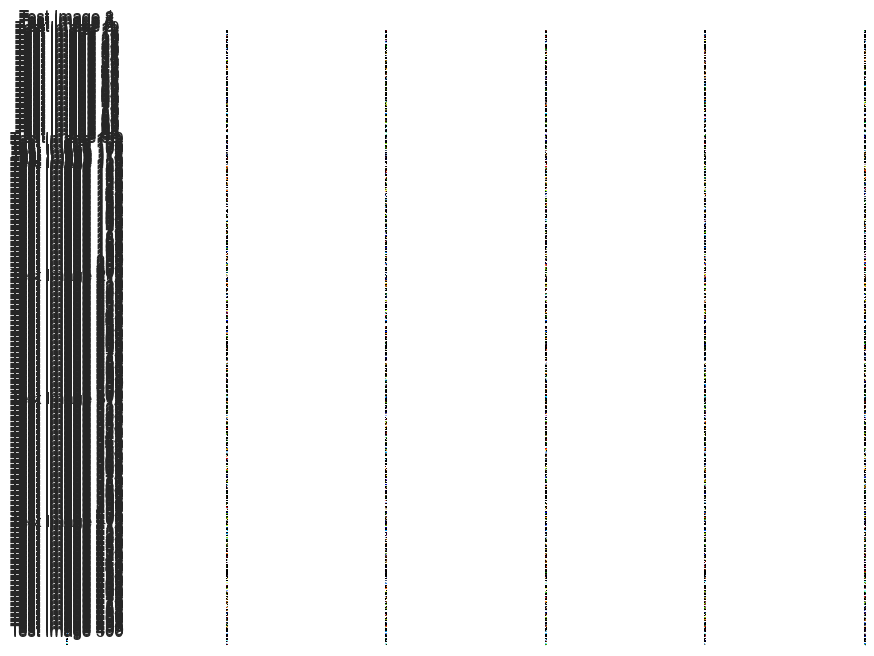

In [133]:
import matplotlib.pyplot as plt
import numpy as np


predictions = knn.predict(x_test)
k_neighbors = 5

# Samples, 
distances, indices = knn.kneighbors(x_test, n_neighbors=k_neighbors)

num_test_images = len(x_test)

# Set up the plot
plt.figure(figsize=(12, 8))


for i in range(num_test_images):
    plt.subplot(num_test_images, 6, i*6 + 1)  # Plot the original image
    plt.imshow(x_test[i].reshape((32,32,3)), cmap='gray')
    plt.axis('off')
    plt.title(f'Test Image {i + 1}')
    
    for j, idx in enumerate(indices[i]):
        plt.subplot(num_test_images, 6, i*6 + j + 2)  # Plot the predicted class
        plt.imshow(x_train[idx].reshape((32,32,3)), cmap='gray')
        plt.axis('off')
        
# Adjust layout
plt.tight_layout()
plt.show()
